# Bonds 3

This notebook presents a yield curve model (a simplified Vasicek model) and then uses it to improve the duration hedging approach.

## Load Packages and Extra Functions

In [1]:
using Printf

include("src/printmat.jl")
include("src/BondCalculations.jl");

In [2]:
using Plots, LaTeXStrings
default(size = (480,320),fmt = :png)

# Predictions from an AR(1)

Consider an AR(1) with mean $\mu$

$r_{t+1}-\mu=\rho\left(  r_{t}-\mu\right)  +\varepsilon_{t+1}$

The forecast (based on information in $t$) for $t+s$ is

$\text{E}_{t}r_{t+s}=\left(  1-\rho^{s}\right)  \mu+\rho ^{s}r_{t}.$

In the the cells below, we code a function for these forecasts and then plot the results (for many forecasting horizons and also for several different starting values).

In [3]:
"""
    AR1Prediction(r0,ρ,μ,s)

Calculate forecast from AR(1)

# Input
r0,ρ,μ,s: scalars
"""
AR1Prediction(r0,ρ,μ,s) = (1-ρ^s)*μ + ρ^s*r0;

In [4]:
(μ,ρ) = (0.05,0.975)

printlnPs("Prediction for t+50, assuming current r=0.07: ",AR1Prediction(0.07,ρ,μ,50))

Prediction for t+50, assuming current r=0.07:      0.056


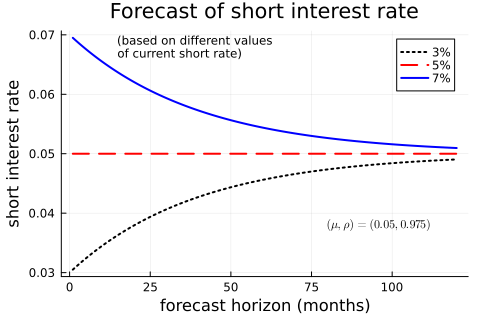

In [5]:
sMax    = 120                                #make forecasts for many horizons and initial values
s_range = 1:sMax                             #different horizons, months
r₀      = [0.03,0.05,0.07]

xPred = fill(NaN,sMax,length(r₀))                #xPred[maturity,r₀ value]
for s in s_range, j = 1:length(r₀)
    xPred[s,j] = AR1Prediction(r₀[j],ρ,μ,s)
end


txt = text(L"(\mu,\rho) = (%$μ,%$ρ)",8,:left)   #laTeX string to plot, notice %$
p1 = plot( s_range,xPred,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:dot :dash :solid],
           label = ["3%" "5%" "7%"],
           title = "Forecast of short interest rate",
           xlabel = "forecast horizon (months)",
           ylabel = "short interest rate",
           annotation = [(80,0.038,txt),
                    (15,0.068,text("(based on different values\nof current short rate)",8,:left))] )
display(p1)

# The Vasicek Model

The simpified (because of no risk premia) Vasicek model implies that

$y_{t}(n) =a(n)+b(n)r_{t} \: \textrm{, where }$

$b(n)     =(1-\rho^{n})/[(1-\rho)n],$

$a(n)     = \mu\left[  1-b(n)\right].$

In the example, $y_{t}(36)$ which corresponds to `y[36]` in the code, is the (annualized) continuously compounded interest rate for a bond maturing in 36 months (3 years).

In the cells below, we code a function for this model and then plots the results for many different maturities (horizons) and several initial values of the short interest rate.

### A Remark on the Code

The code (used below)
```b = ρ == 1.0 ? 1.0 : (1-ρ^n)/((1-ρ)*n)```
is the same as 
```
if p == 1.0
    b = 1.0
else
    b = (1-ρ^n)/((1-ρ)*n)
end
```

In [6]:
"""
    Vasicek(r,ρ,μ,n)

Vasicek model: calculate interest rate and (a,b) coeffs

# Input
r,ρ,μ,n: scalars

n is the maturity, but this could be measured in any unit (months, years, etc),
but changing the units require recalibrating ρ
"""
function Vasicek(r,ρ,μ,n)
    b = ρ == 1.0 ? 1.0 : (1-ρ^n)/((1-ρ)*n)   #if-else-end
    a = μ*(1-b)
    y = a + b*r
    return y,a,b
end

Vasicek

In [7]:
y = fill(NaN,sMax,length(r₀))         #interest rates, different starting values in columns
ab = fill(NaN,sMax,2)                 #a and b coefs
for n in s_range, j = 1:length(r₀)
    #local a, b                       #local/global is needed in script
    (y[n,j],a,b) = Vasicek(r₀[j],ρ,μ,n)
    if j == 1
        ab[n,:] = [a,b]               #update ony if j==1, the same across r₀ values
    end
end

printblue("a and b for the first few horizons (months):")
printmat([ab[1:4,1]*10 ab[1:4,2]];colNames=["a*10","b"],rowNames=string.(s_range[1:4]),cell00="horizon")

a and b for the first few horizons (months):
horizon      a*10         b
1           0.000     1.000
2           0.006     0.988
3           0.012     0.975
4           0.018     0.963



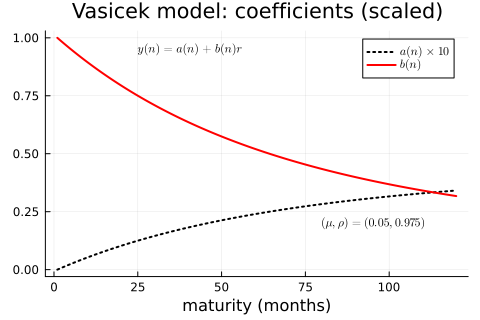

In [8]:
p1 = plot( s_range,ab.*[10 1],
           linecolor = [:black :red],
           linestyle = [:dot :solid],
           linewidth = 2,
           label = [L"a(n) \times 10" L"b(n)"],
           title = "Vasicek model: coefficients (scaled)",
           xlabel = "maturity (months)",
           annotation = [(80,0.2,txt),
                    (25,0.95,text(L"y(n) = a(n) + b(n)r",8,:left))] )
display(p1)

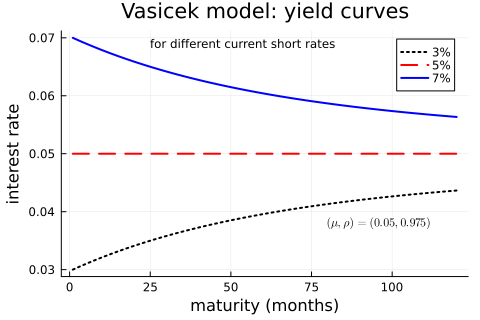

In [9]:
p1 = plot( s_range,y,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:dot :dash :solid],
           label = ["3%" "5%" "7%"],
           title = "Vasicek model: yield curves",
           xlabel = "maturity (months)",
           ylabel = "interest rate",
           annotation = [(80,0.038,txt),
                    (25,0.069,text("for different current short rates",8,:left))] )
display(p1)

# Hedging Using the Vasicek Model

The change of the (value of the) overall portfolio is 

$\Delta V=v\Delta P_{H}-\Delta P_{L}$

The code below calculates the $v$ value that makes $\Delta V \approx 0$, that is, $v=\Delta P_{L}/\Delta P_{H}$.

## Information about the Two Bonds

In the example below, the liability pays 0.2 every 12 months for 10 years. The hedge bond is a 3-year zero coupon bond.

In [10]:
(cfL,mL) = (fill(0.2,10),1:10)      #liability, 0.2 in year 1,2...,10

(cfH,mH) = (1,3);                    #hedge bond, 3-year zero-coupon bond

## Calculate Yield Curves

at two different values of the current short rate: $r_0$ and $r_1$. This is similar to the previous figure on the Vasicek yield curves, but here for the horizons that we need in order to (later) calculate the prices of the liability and hedge bond.

Motice that the periods in the Vasicek model are months, that is, corresponding to the maturity of the short rate. This means, for instance, that the 3-year spot rate is element 36 of the `y₀` vector calculated below.

In [11]:
nMax = maximum([mL;mH])*12        #number of months to calculate spot rates for
ρ = 0.975                         #experiment with this
μ = 0.05

r₀ = 0.05                         #initial (day 0) short interest rate
r₁ = 0.03                         #another possible short rate

nM   = 1:nMax                     #time to maturity (months)

y₀ = [Vasicek(r₀,ρ,μ,n)[1] for n in nM]    #yield curve starting at r₀
y₁ = [Vasicek(r₁,ρ,μ,n)[1] for n in nM]    #yield curve starting at r₁
b  = [Vasicek(r₁,ρ,μ,n)[3] for n in nM]    #b, from y=a*br

nL = indexin(mL,nM/12)    #indices in nM (months) that fit with mL (years), used later
nH = indexin(mH,nM/12)

printred("similar to the previous figure of yield curves. Plot y₀ and y₁ to verify that.")

similar to the previous figure of yield curves. Plot y₀ and y₁ to verify that.


## Brute Force Calculation of Hedge Ratio

As a preliminary exercise,  we calculate the bond prices (of both the liability and the hedge bond) at the initial yield curve and also at the new yield curve, 

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\exp\left[m_{k} y(m_{k})\right]  }$,

where $y(m_k)$ is the continuously compounded (annualized) interest rate on a bond maturing in $m_k$ years.

In a second step, we calculate a hedge ratio ($v$) as

$v = \Delta P_L / \Delta P_H,$

where $\Delta P$ is the change in the bond price (as the short rate changes).

### Remark on the Code
 - `y₀[nL]` picks out those (monthly) maturities in the yield curve that correspond to the annual maturities `mL` used in the definition of the liability cash flow.

In [12]:
PL₀ = BondPrice(y₀[nL],cfL,mL;ContRateQ=true)       #liability, before, /12 to get years
PL₁ = BondPrice(y₁[nL],cfL,mL;ContRateQ=true)       #after
ΔPL = PL₁ - PL₀                                     #change of liability value

PH₀ = BondPrice(y₀[nH],cfH,mH;ContRateQ=true)       #hedge bond
PH₁ = BondPrice(y₁[nH],cfH,mH;ContRateQ=true)
ΔPH = PH₁ - PH₀                                     #change of hedge bond value
v = ΔPL/ΔPH

printblue("Bond prices (according to the Vasicek model) at different r values")
xy = [PL₀ PH₀;PL₁ PH₁;(PL₁-PL₀) (PH₁-PH₀)]
printmat(xy;colNames=["PL","PH"],rowNames=["at $r₀","at $r₁","Δ"])

printlnPs("Hedge ratio implied by (finite difference) approach")
xy = [v;v*PH₀/PL₀]
printmat(xy,rowNames=["v","v*PH₀/PL₀"])

Bond prices (according to the Vasicek model) at different r values
               PL        PH
at 0.05     1.535     0.861
at 0.03     1.609     0.896
Δ           0.074     0.035

Hedge ratio implied by (finite difference) approach
v             2.106
v*PH₀/PL₀     1.181



## Hedge Ratio from Spot Durations

We now apply a spot duration approach instead.

The `BondDurationSpot()` function calculates spot rate durations, $D_k$ for $k=1,...,K$, that is, derivatives of the bond price wrt. the (vector of) spot rates. This can be used to calculate (approximate) bond price values as 

$\Delta P = -P [\sum_{k=1}^{K} D_k b(m_k)] \Delta r$,

where $b(m_k)$ is the coefficient in the Vasicek model for horizon $m_k$. As before, remember that the output from the Vasicek model is indexed by months (not years). Apply the equation to the liability and to the hedge bond (which have different $D_k$ values).

As before, the hedge ratio is calculated as 

$v = \Delta P_L / \Delta P_H,$

so the $\Delta r$ terms cancel.

In [13]:
"""
    BondDurationSpot(Y,cf,m;ContRateQ=false)

Calculate (modified) spot rate durations.

# Input
- `Y::Vector`:             spot rates
- `cf::Vector`:            cash flows
- `m::Vector`:             time to cash flows
- `P::Number`:             bond price
- `ContRateQ::Bool`:       if `true`: continuously compounded rates

"""
function BondDurationSpot(Y,cf,m;ContRateQ=false)
  P = BondPrice(Y,cf,m;ContRateQ)         #implied bond price
  if ContRateQ
    D = m.*cf.*exp.(-m.*Y)
  else
    D = m.*cf./(1.0.+Y).^(m.+1)
  end
  D = D/P
  return D, P
end

BondDurationSpot

In [14]:
(DurSpotL,PL) = BondDurationSpot(y₀[nL],cfL,mL;ContRateQ=true)
ΔPL = -PL₀*sum(b[nL].*DurSpotL)
(DurSpotH,PH) = BondDurationSpot(y₀[nH],cfH,mH;ContRateQ=true)
ΔPH = -PH₀*sum(b[nH].*DurSpotH)
v = ΔPL/ΔPH

printblue("Hedge ratio from spot durations combined with the Vasicek model")
xy = [v;v*PH₀/PL₀]
printmat(xy,rowNames=["v","v*PH₀/PL₀"])

printblue("The hedge ratio is similar (but not identitical)
to the one obtained by the 'brute force' approach.\n")

printred("Notice: ρ is important for the hedge ratio v.
Try also ρ=1 (change in one of the first cells in the notebook)
to see how it affects the hedge ratio v.")

Hedge ratio from spot durations combined with the Vasicek model
v             2.093
v*PH₀/PL₀     1.174

The hedge ratio is similar (but not identitical)
to the one obtained by the 'brute force' approach.

Notice: ρ is important for the hedge ratio v.
Try also ρ=1 (change in one of the first cells in the notebook)
to see how it affects the hedge ratio v.
